In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from modules.representation_schemes import enc1d_features, get_PTR_features, get_vectorized_featues, properties_from_comp
from modules.model_select import get_scoring_dict, model_pipeline

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
hardness_df_loc = 'dataset/hardness.csv'
hardness_df = pd.read_csv(hardness_df_loc)
comps = hardness_df['Composition'].values
y = hardness_df['HV'].values
samples_per_bin, bins, = np.histogram(hardness_df['HV'], bins=np.arange(100,1000,100))    # Doane's method worked best for me
min_bin_size = samples_per_bin.min()
# compute the maximum batch size possible, using all samples from the bin with lowest population
n_bins = len(samples_per_bin)
hardness_df['bin_name'] = np.digitize(hardness_df['HV'].values,bins)

In [ ]:
with open('misc/pca_components.pkl','rb') as fid:
    component_dict = pickle.load(fid)

In [35]:
np.random.seed(0)
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    pipelines, scoring_dict = model_pipeline(), get_scoring_dict()
    X_train, X_test, y_train, y_test = train_test_split(features, y.ravel(), test_size=0.20,random_state = 0,stratify=hardness_df['bin_name'])
    rmse = {'train':[],'test':[]}
    r = {'train':[],'test':[]}
    train_rmse_results = []
    train_r_results = []
    test_rmse_results = []
    test_r_results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=10, random_state=21, shuffle=True)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring_dict,return_train_score=True)
        rmse['train'].append(list(cv_results['train_rmse']))
        r['train'].append(list(cv_results['train_r']))
        rmse['test'].append(list(cv_results['test_rmse']))
        r['test'].append(list(cv_results['test_r']))
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results['test_r'].mean(), cv_results['test_r'].std())
        print(msg)
    method_dict[method] = {'rmse':rmse,'r':r}
save_loc = 'results/model_selection_hardness.json'
with open(save_loc,'w') as fid:
    json.dump(method_dict,fid)


atomic
Linear: 0.888681 (0.038066)
Lasso: 0.888333 (0.038252)
Ridge: 0.888711 (0.038057)
KNeighbor: 0.908013 (0.041311)
GBR: 0.921056 (0.026683)
RF: 0.926374 (0.019397)
XGB: 0.917759 (0.030980)
SVR-lin: 0.883562 (0.043115)
SVR-poly: 0.538271 (0.127462)
SVR-rbf: 0.837253 (0.059561)
MLP: 0.780537 (0.109255)
random
Linear: 0.884748 (0.042302)
Lasso: 0.885433 (0.041016)
Ridge: 0.884821 (0.042317)
KNeighbor: 0.863193 (0.061005)
GBR: 0.909282 (0.026340)
RF: 0.905348 (0.026612)
XGB: 0.906510 (0.018133)
SVR-lin: 0.875531 (0.043097)
SVR-poly: 0.480314 (0.135160)
SVR-rbf: 0.804808 (0.061036)
MLP: 0.766794 (0.113726)
pettifor
Linear: 0.886469 (0.035511)
Lasso: 0.886530 (0.035736)
Ridge: 0.886474 (0.035522)
KNeighbor: 0.902525 (0.040337)
GBR: 0.921543 (0.022093)
RF: 0.921291 (0.026565)
XGB: 0.917703 (0.030406)
SVR-lin: 0.879380 (0.039393)
SVR-poly: 0.619174 (0.094621)
SVR-rbf: 0.835754 (0.055110)
MLP: 0.802730 (0.067059)
mod_pettifor
Linear: 0.886469 (0.042326)
Lasso: 0.886673 (0.041826)
Ridge: 0.

In [36]:
def get_metrics(pipelines):
    metric_list = []
    for i in range(len(pipelines)):
       metric_list.append(pipelines[i][0])
    return metric_list

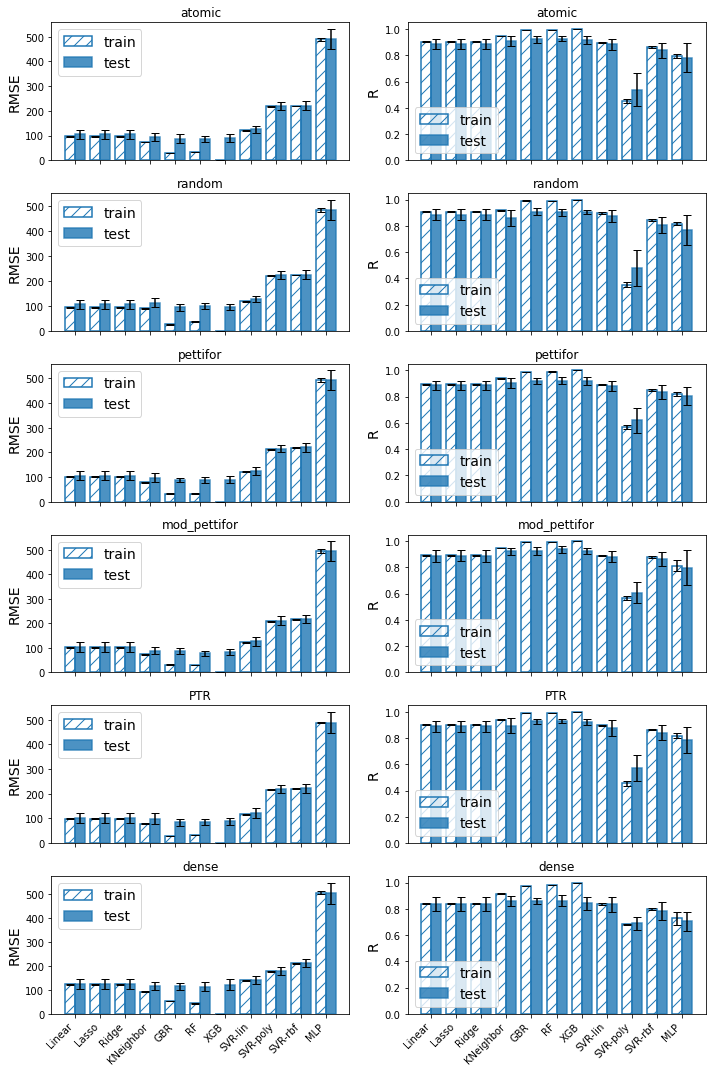

In [47]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
metrics = get_metrics(pipelines)
scores= ['rmse','r']
fig, ax = plt.subplots(len(methods),2,figsize=(10,15), sharex=True)
#ax = ax.flatten()
for m,method in enumerate(methods):
    for i in range(len(scores)):
        metric = scores[i]
        rmse = method_dict[method]['rmse']
        r = method_dict[method]['r']
        for k, key in enumerate(['train','test']):
            if key == 'train':
                mf = 'none'
                h = '//'
                a = 1.0
            else:
                mf = 'tab:blue'
                h = ''
                a = 0.8
            if metric == 'rmse':
                avg = -np.mean(rmse[key],axis=1)
                std = np.std(rmse[key],axis=1)
            elif metric == 'r':
                avg = np.mean(r[key],axis=1)
                std = np.std(r[key],axis=1)
            ax[m,i].bar(np.arange(len(metrics))+0.2*(2*k-1),avg,yerr = std,facecolor=mf, alpha=a, hatch=h, 
            width=0.40, color='tab:blue', edgecolor='tab:blue', linewidth=1.5, capsize=4,label=key)
            ax[m,i].set_xticks(np.arange(len(metrics)))
            ax[m,i].set_xticklabels(metrics, rotation=45, ha='right')
            ax[m,i].legend(fontsize=14)
            if metric == 'rmse':
                #ax.set_ylim(0, 5)
                ax[m,i].set_ylabel('RMSE',fontsize=14)
            elif metric == 'r':
                #ax.set_ylim(0, 1.01)
                ax[m,i].set_ylabel('R',fontsize=14)
            ax[m,i].set_title(method,y=1)
fig.tight_layout()

#plt.savefig('comp_vec_models.pdf')

Using RandomForest as model

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [6]:
#fixed folds
np.random.seed(0)
kf = KFold(n_splits=10, shuffle=True, random_state = 0)
kf.get_n_splits(comps)

NameError: name 'comps' is not defined

In [ ]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    gridCV = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,cv=10)
    pipe= Pipeline([('Scaler', StandardScaler()),('grid',gridCV)])